# Introduction <a name="introduction"></a>

In this study, we analyzed data that directly provided interbeat intervals between consecutive heartbeats. To process these data, we first computed the cumulative heartbeat time series and divided it into segments. Next, polynomials of specific degrees were fitted to each segment to extract potential trends.

We then computed the probability density function (PDF) of heart rate changes and compared it with a Gaussian distribution. Additionally, we examined the cascade model as a possible descriptor of heart rate variability. However, our findings generally indicated that these models did not adequately align with the observed data. Ultimately, the results of this study suggest that heart rate variability exhibits self-similarity and scale invariance, resembling the characteristics of a critical system rather than a cascade model.

# Imported libraries <a name="imported_libraries"></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from obspy.signal.detrend import polynomial
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import norm
from sklearn.metrics import r2_score
from tqdm import tqdm
import sys
from scipy.optimize import curve_fit


In [3]:


data_files = ["000","002","003","005","006","008","009","010","011","013"]
data = []
for i in data_files:
    f = open("data/" + i + ".txt","r")

    data0 = []

    for i in f.readlines():
        x = i.strip()
        if x:
            data0.append(int(x))

    data.append(data0)


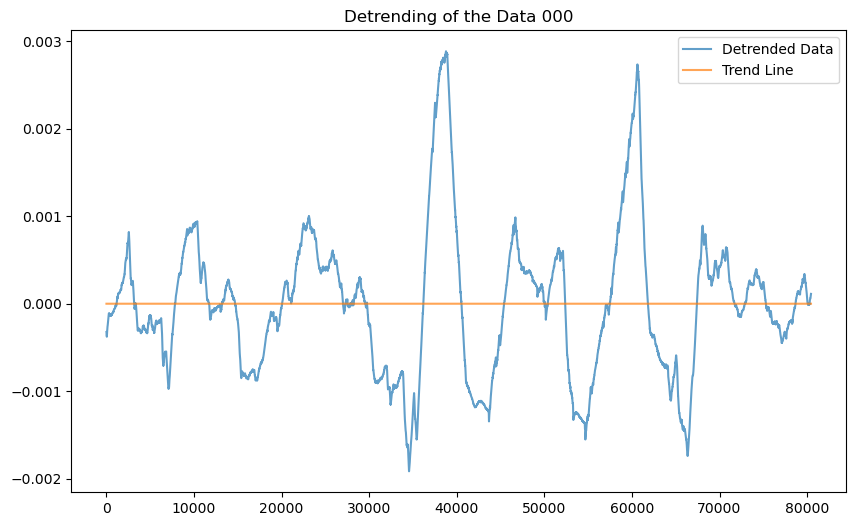

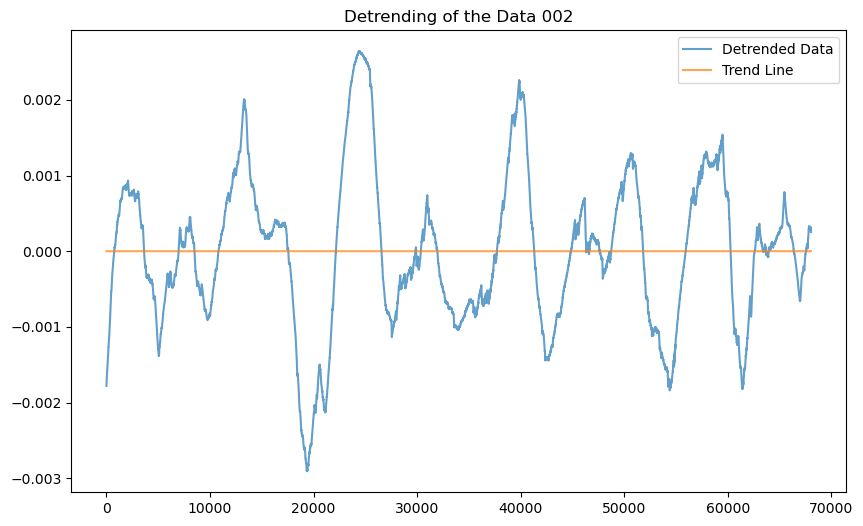

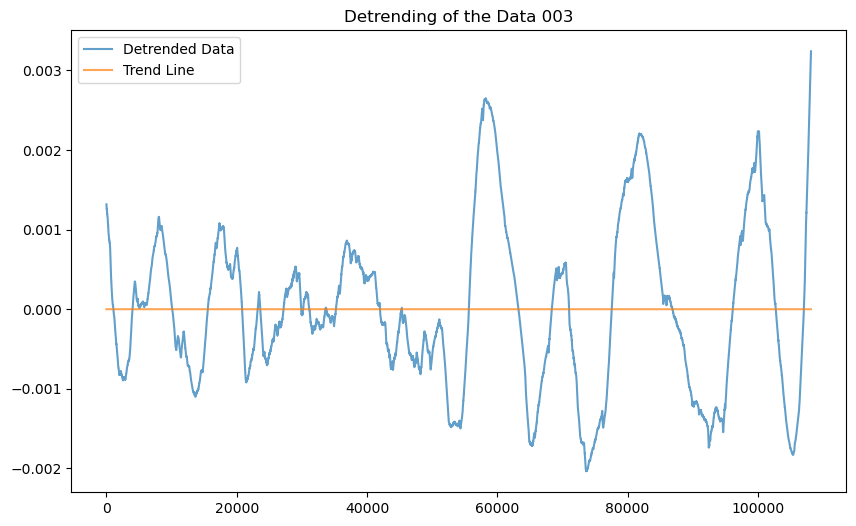

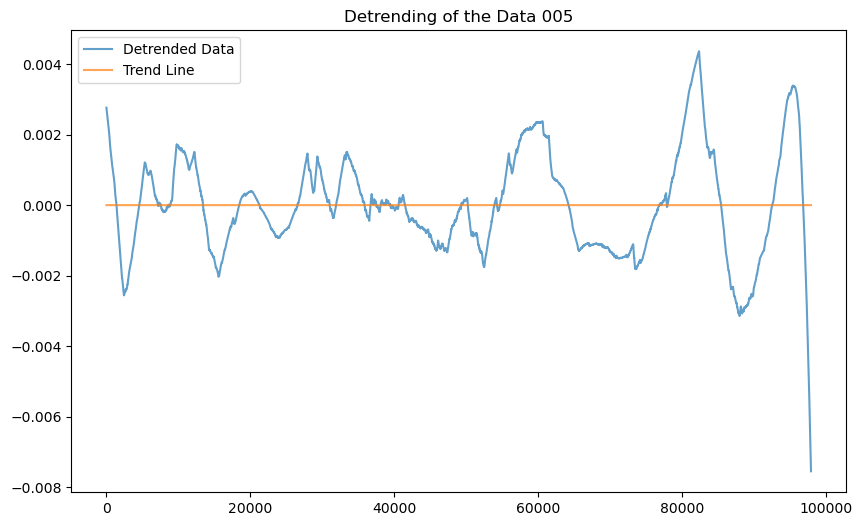

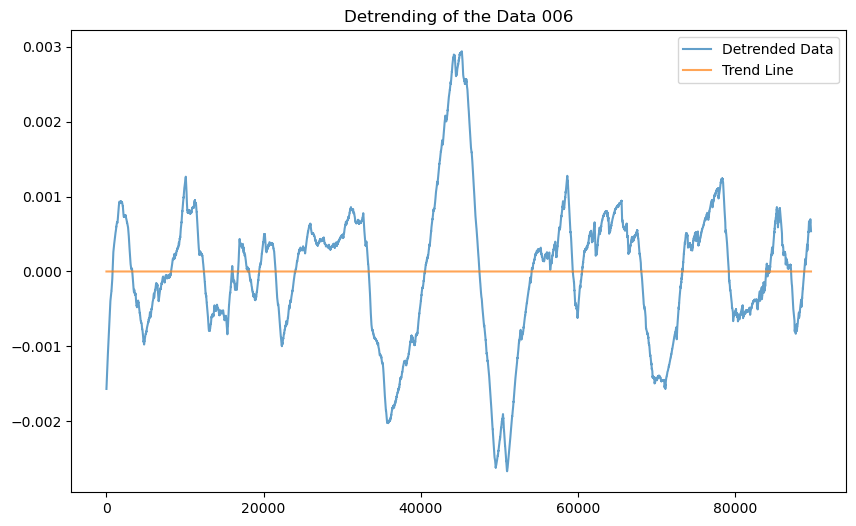

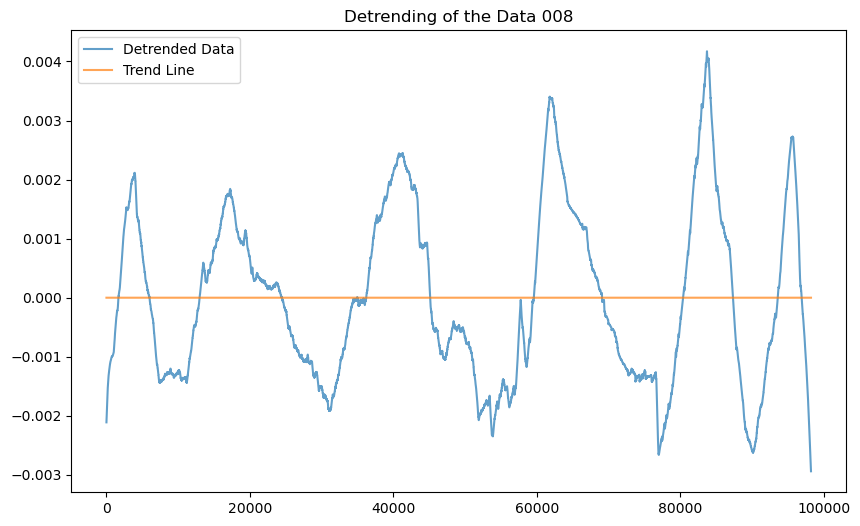

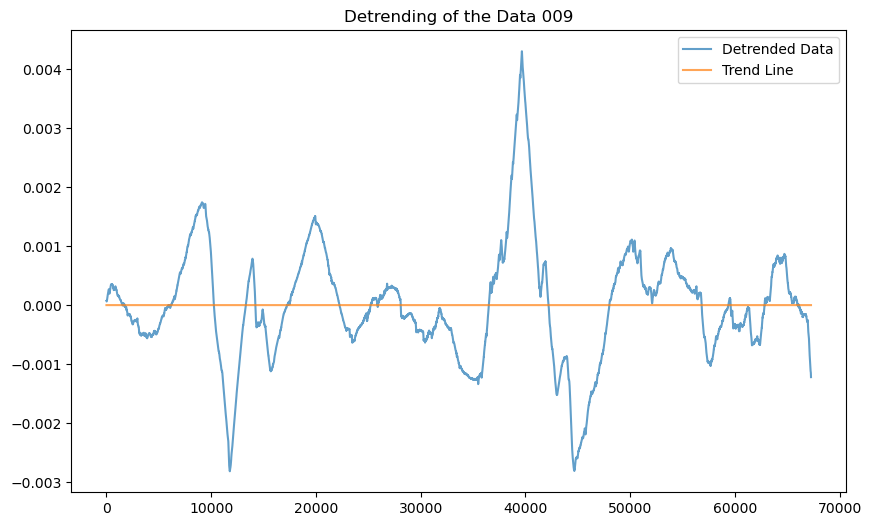

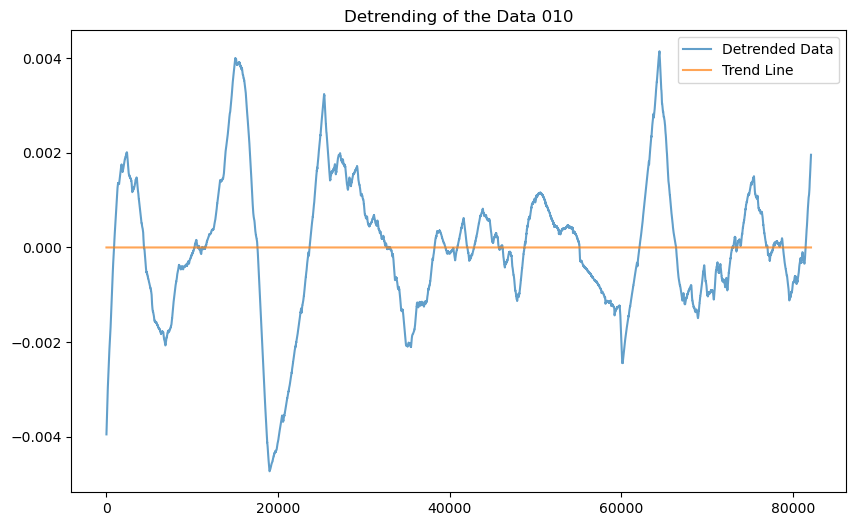

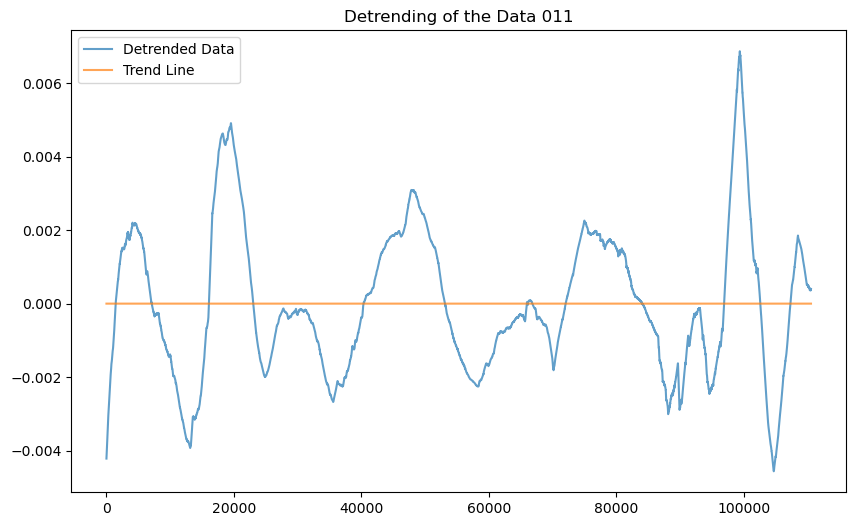

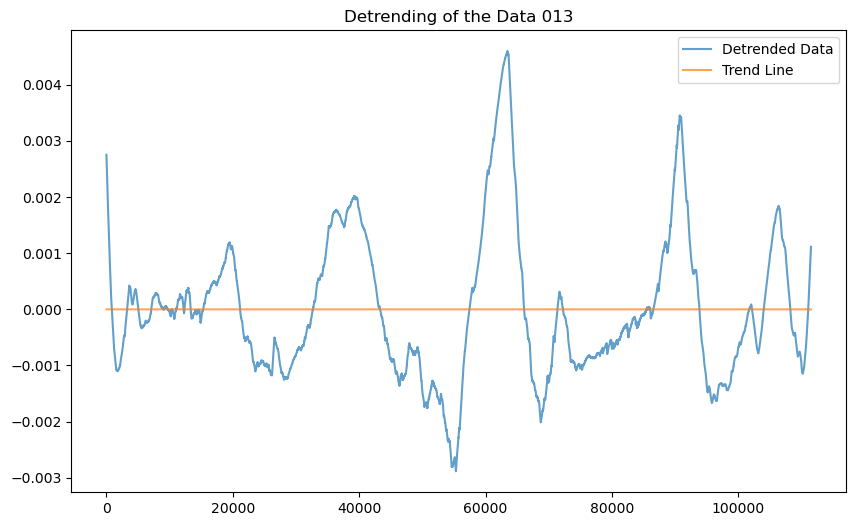

In [4]:
for i in range(len(data)):
    data0 = np.cumsum(np.array(data[i]))

    mean = np.mean(data0)
    std_dev = np.std(data0)
    data0_norm = (data0 - np.min(data0)) / (np.max(data0) - np.min(data0))

    x = np.arange(len(data0_norm))
    degree = 10
    p = Polynomial.fit(x, data0_norm, degree)
    trend = p(x)
    detrended_data = data0_norm - trend

    p2 = Polynomial.fit(x, detrended_data, 1)
    trend2 = p2(x)

    plt.figure(figsize=(10, 6))
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.plot(trend2, label="Trend Line", alpha=0.7)
    plt.title("Detrending of the Data " + data_files[i])

    plt.legend()
    plt.show()


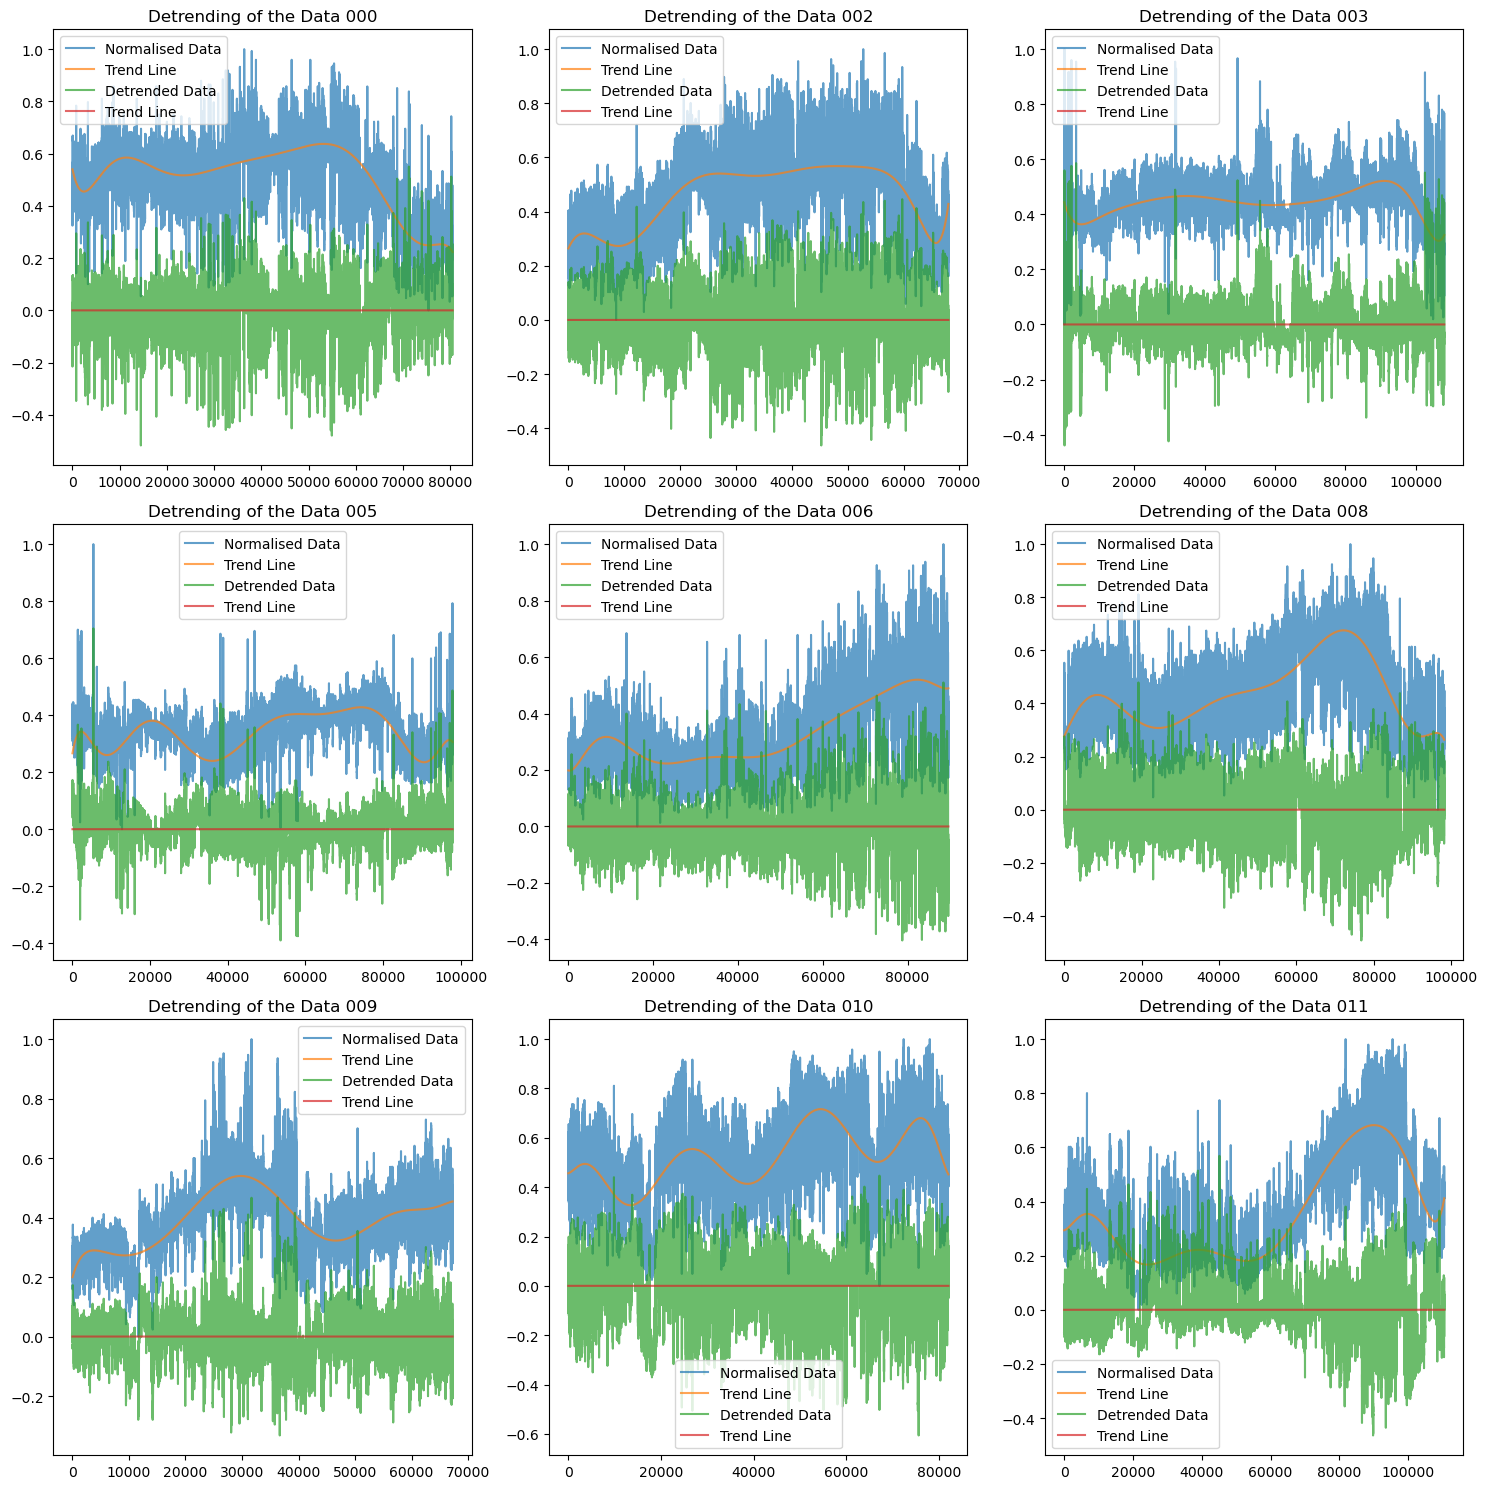

In [5]:

plt.figure(figsize=(15, 15))

for i in range(len(data[:9])):  # the last data is not included in order to plot as 3x3
    data0 = np.array(data[i])
    #Normalize data
    data0_norm = (data0 - np.min(data0)) / (np.max(data0) - np.min(data0))

    x = np.arange(len(data0_norm))
    degree = 10
    p = Polynomial.fit(x, data0_norm, degree)
    trend = p(x)
    detrended_data = data0_norm - trend

    p2 = Polynomial.fit(x, detrended_data, 1)
    trend2 = p2(x)

    plt.subplot(3, 3, i + 1)  # Creates subplots in a 3x3 grid
    plt.plot(data0_norm, label="Normalised Data", alpha=0.7)
    plt.plot(trend, label="Trend Line", alpha=0.7)
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.plot(trend2, label="Trend Line", alpha=0.7)
    plt.title("Detrending of the Data " + data_files[i])
    plt.legend()


plt.tight_layout()
plt.show()


In [6]:
def detr_and_standardize(b_i, s):
    '''
    b_i: interbeat time series
    s: list of times scale

    output : df: dataframe containing in the rows the differences delta_s B(i)
    '''
    # build a cumulative sum over b_i
    B=np.cumsum(b_i)

    # defining the variable we'll need
    Bstar={}

    # iterate over the times scale
    for j,k in enumerate(s):   # j goes from 0 to len(s), k follow s
        c=int(len(B)/(2*k) )   # number of boxes
        print(c)

        # defining the variable we'll need
        detrends=[]
        Bstar.setdefault(k, [])

        # removes trends thanks to the function polynomial in the obspy package
        for i in range(c):
            detrend = polynomial(B[i*2*k:(i+1)*2*k], order = 3, plot = False)#z_m
            detrends.append(detrend)
        vect=np.array(detrends)
        print(np.shape(vect))

        # evaluate B* sliding in time over the boxes
        for i in range(c):
            for l in range(2*k):
                    Bstar[k].append(detrends[i][l])
        print(Bstar.keys())

    DeltaB = {}
    # compute the differences and stores them into a dataframe df
    for l in s:
        std = np.std(Bstar[l])
        DeltaB.setdefault(l, [])
        for g in range( len(Bstar[l])-l):
            diff = (Bstar[l][g+l] - Bstar[l][g])/std
            DeltaB[l].append(diff)

    df = pd.DataFrame.from_dict(DeltaB, orient = 'index')

    return(df)

In [7]:
s_list = np.array([10,25,50,125,250,500,625,1000,1250,1500])



In [8]:
df = detr_and_standardize(data[0],s_list)
print(len(data[0]))

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])
80
(80, 1000)
dict_keys([10, 25, 50, 125, 250, 500])
64
(64, 1250)
dict_keys([10, 25, 50, 125, 250, 500, 625])
40
(40, 2000)
dict_keys([10, 25, 50, 125, 250, 500, 625, 1000])
32
(32, 2500)
dict_keys([10, 25, 50, 125, 250, 500, 625, 1000, 1250])
26
(26, 3000)
dict_keys([10, 25, 50, 125, 250, 500, 625, 1000, 1250, 1500])
80441


In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,80420,80421,80422,80423,80424,80425,80426,80427,80428,80429
10,0.697768,1.336966,0.447956,0.547703,-0.642307,-1.082008,-0.135536,0.951874,-0.283755,-0.159704,...,-0.721353,1.392381,-0.264772,1.169228,0.342519,-0.360406,-1.01903,-0.89151,-0.163307,-0.053163
25,-0.265588,0.720604,0.974852,1.166067,1.165610,0.904878,-0.027769,0.039947,-0.212644,-0.871300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,0.614042,0.704672,0.595119,0.658911,0.307939,0.253499,-0.060731,-0.265194,-0.574471,-1.020352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,-2.171694,-1.952479,-1.755279,-1.541743,-1.493625,-1.352467,-1.351715,-1.269595,-1.236170,-1.214755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,-3.128808,-2.922349,-2.674259,-2.413005,-2.245550,-2.023526,-1.890125,-1.688354,-1.566579,-1.379022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,-3.006303,-2.895153,-2.811295,-2.694135,-2.616858,-2.515329,-2.428894,-2.327650,-2.248189,-2.153526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,-1.963202,-1.858282,-1.781255,-1.693970,-1.609359,-1.532595,-1.448159,-1.364134,-1.317703,-1.264246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,-0.089857,-0.043712,-0.015492,0.030818,0.062091,0.096240,0.129027,0.163148,0.186663,0.210164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1250,0.761570,0.789430,0.805390,0.822537,0.834328,0.848857,0.853896,0.861673,0.858582,0.852718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500,1.209131,1.226686,1.244250,1.258821,1.261533,1.273937,1.279939,1.289087,1.281192,1.279716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


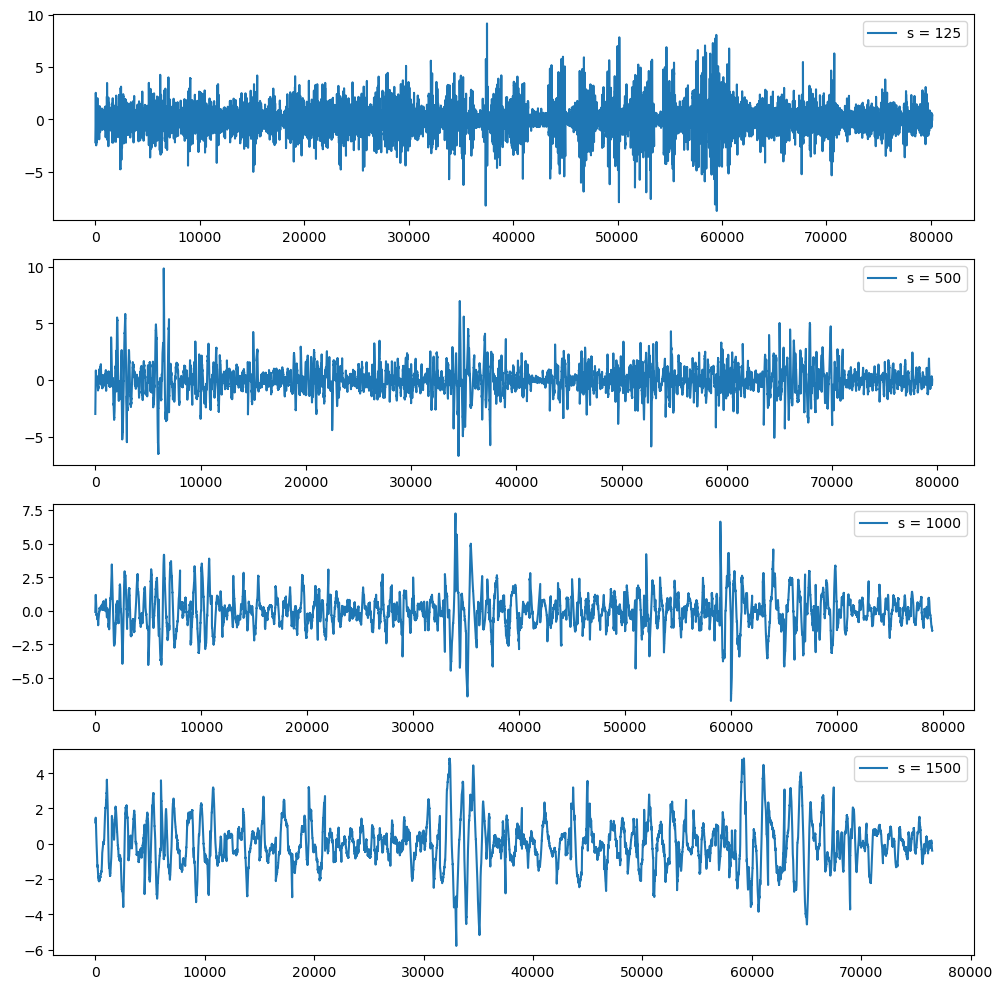

In [10]:
first_row = df.iloc[3].to_numpy()
second_row = df.iloc[5].to_numpy()
third_row = df.iloc[7].to_numpy()
forth_row = df.iloc[9].to_numpy()
plt.figure(figsize=(10, 10))

# subplot for the first row corresponds to the first time scale in s_list (in this case, s = 10).
plt.subplot(4, 1, 1)
plt.plot(first_row, label="s = 125")
plt.legend(loc="upper right")
# subplot for the second row corresponding to the second time scale in s_list (e.g., s = 125 if present).
plt.subplot(4, 1, 2)
plt.plot(second_row, label="s = 500")
plt.legend(loc="upper right")
# subplot for the third row corresponding to the second time scale in s_list (e.g., s = 1000 if present).
plt.subplot(4, 1, 3)
plt.plot(third_row, label="s = 1000")
plt.legend(loc="upper right")

# subplot corresponding to the second time scale in s_list (e.g., s = 1500 if present).
plt.subplot(4, 1, 4)
plt.plot(forth_row, label="s = 1500")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Imported libraries <a name="imported_libraries"></a>

## Gaussian fit <a name="gauss"></a>

  0%|          | 0/5 [00:00<?, ?it/s]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])


 20%|██        | 1/5 [00:01<00:07,  1.85s/it]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])


 40%|████      | 2/5 [00:03<00:05,  1.67s/it]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])


 60%|██████    | 3/5 [00:04<00:03,  1.63s/it]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])


 80%|████████  | 4/5 [00:06<00:01,  1.60s/it]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
804
(804, 100)
dict_keys([10, 25, 50])
321
(321, 250)
dict_keys([10, 25, 50, 125])
160
(160, 500)
dict_keys([10, 25, 50, 125, 250])


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_3374/1970434141.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


        $R^2$      RMSE     NRMSE
s                                
10   0.914609  0.000644  0.071179
25   0.884530  0.000304  0.078008
50   0.873728  0.000160  0.080551
125  0.910590  0.000053  0.072173
250  0.919358  0.000025  0.067940


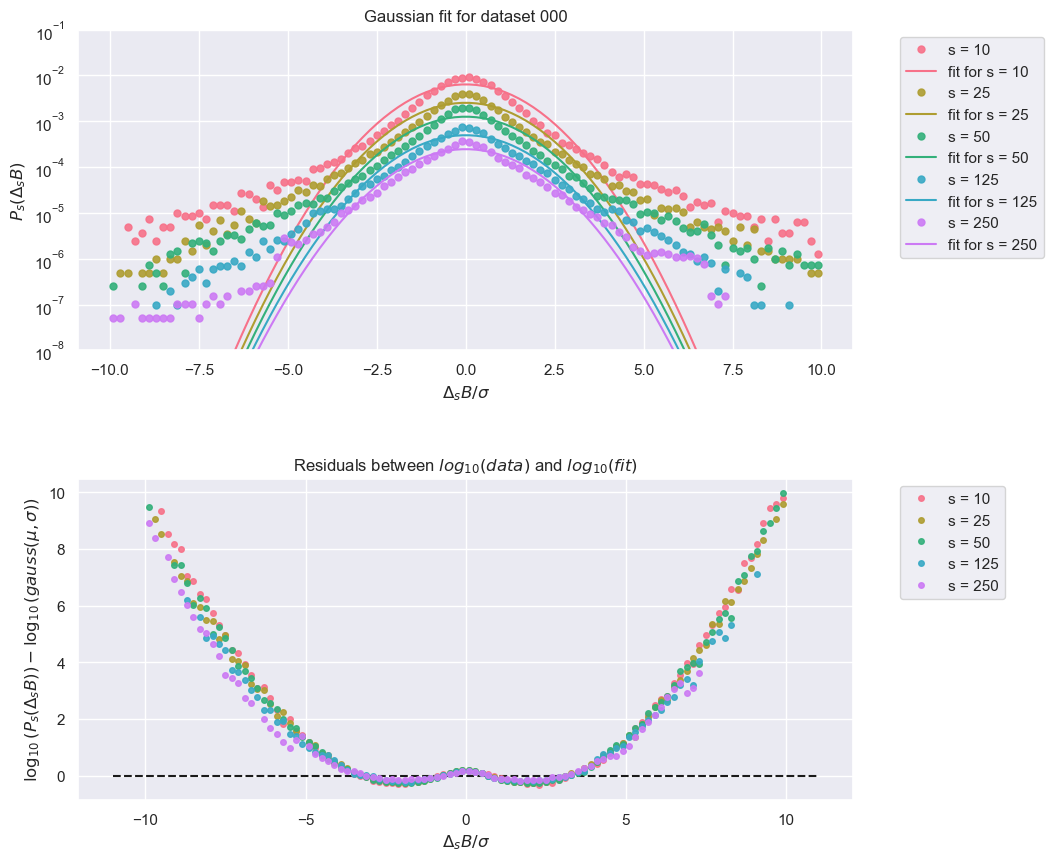

In [11]:
#exactly the same as the previous year code
# Set style for the plots
sns.set(style="darkgrid")

# Initialize figure and axes with increased vertical spacing
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})
ax[0].set_title("Gaussian fit for dataset 000")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")
ax[1].hlines(0, -11, 11, linestyles="dashed", colors="k")

# Initialize the output table
table = {"s": [], "$R^2$": [], "RMSE": [], "NRMSE": []}

# Define different s values
s_list = [10, 25, 50, 125, 250]  # Different sample scales
colors = sns.color_palette("husl", len(s_list))  # Assign different colors for each s



for j, s in enumerate(tqdm(s_list)):
    # Load data (assuming 'data' and 'detr_and_standardize' are defined)
    df = detr_and_standardize(data[0], s_list)
    y = df.loc[s]
    y = y.dropna()  # Remove NaN values

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=100, range=(-10, 10))
    bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit = bins_centers[bins_index_fit]
    histo_fit = histo[bins_index_fit]

    # Fit Gaussian distribution
    mu, sigma = norm.fit(y)
    y_fit = norm.pdf(bins_c_fit, mu, sigma)
    y_fit = y_fit / (s * np.sum(y_fit))

    # Plot histogram data
    histo_plot = histo_fit / (s * np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=5, alpha=0.9, label=f"s = {s}")
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")

    # Compute residuals and plot on second subplot
    residuals_log10 = np.log10(histo_plot) - np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=4, alpha=0.9, label=f"s = {s}")

    # Compute model evaluation metrics
    R2 = r2_score(histo_plot, y_fit)
    RMSE = np.sqrt(np.mean((histo_plot - y_fit) ** 2))
    NRMSE = RMSE / (np.max(histo_plot) - np.min(histo_plot))

    # Store results in the table
    table["s"].append(s)
    table["$R^2$"].append(R2)
    table["RMSE"].append(RMSE)
    table["NRMSE"].append(NRMSE)



# Add legends for both subplots
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Convert results to DataFrame and display
table = pd.DataFrame(table)
table.set_index('s', inplace=True)
print(table)


# Show the plots
plt.tight_layout()
plt.show()


**Key Observations:**


*   Around the center (0 on the x-axis), residuals are small, meaning the Gaussian approximation is good.

*   At both extremes (large positive/negative ΔsBΔs​B), residuals increase, meaning the Gaussian function underestimates the probability of extreme fluctuations.

*  The dashed black horizontal line at 0 indicates the ideal case where the fit perfectly matches the data.


## Castaing fit <a name="castaing"></a>
We fit the data to the following equation, based on the Castaing's function:

 $$\Pi (x) = \int_{0}^{+\infty} {\frac{1}{\sigma \sqrt{2\pi}}} exp(-\frac{x^2}{2\sigma^2}){\frac{1}{\lambda \sqrt{2\pi}} exp(- \frac{ln^2 (\sigma)}{2\lambda^2}) \frac{d\sigma}{\sigma}}$$



**Note:**
The main difference between the cascade model and the Gaussian model is that the standard deviation varies in the cascade model, whereas it remains constant in the Gaussian distribution.

  0%|          | 0/6 [00:00<?, ?it/s]

4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


 17%|█▋        | 1/6 [00:02<00:10,  2.16s/it]

parameters: [0.40455194]
4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


 33%|███▎      | 2/6 [00:04<00:08,  2.03s/it]

parameters: [0.38311614]
4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


 50%|█████     | 3/6 [00:05<00:05,  1.92s/it]

parameters: [0.34995927]
4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


 67%|██████▋   | 4/6 [00:07<00:03,  1.99s/it]

parameters: [0.35292707]
4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


 83%|████████▎ | 5/6 [00:09<00:01,  1.99s/it]

parameters: [0.31138028]
4022
(4022, 20)
dict_keys([10])
1608
(1608, 50)
dict_keys([10, 25])
321
(321, 250)
dict_keys([10, 25, 125])
80
(80, 1000)
dict_keys([10, 25, 125, 500])
40
(40, 2000)
dict_keys([10, 25, 125, 500, 1000])
26
(26, 3000)
dict_keys([10, 25, 125, 500, 1000, 1500])


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]

parameters: [0.26224441]



/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_1746/2906246357.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


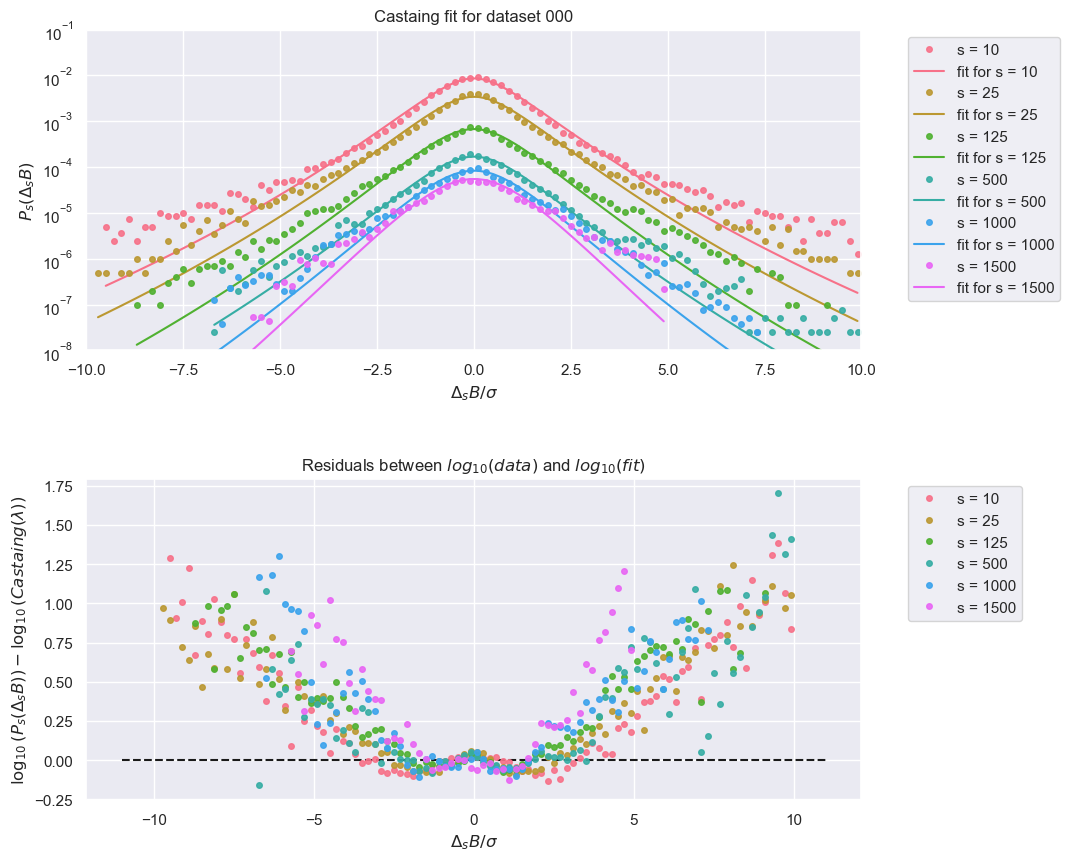

In [ ]:
# Set style for the plots
sns.set(style="darkgrid")

# Histograms' parameters
n_bins = 100
hist_range = 10
marker_size = 4

# Initialize figure and axes with increased vertical spacing
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})
ax[0].set_title("Castaing fit for dataset 000")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 0.1)
ax[0].set_xlim(-hist_range, hist_range)

ax[1].set_title("Residuals between $log_{10}(data)$ and $log_{10}(fit)$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(Castaing(\lambda))$")
ax[1].hlines(0, -hist_range - 1, hist_range + 1, linestyles="dashed", colors="k")

# Define different s values
s_list = [10,25,125, 500, 1000, 1500]  # Different sample scales

#for the following code bloc
lambdas= np.zeros(len(s_list))
lambdas_err = np.zeros(len(s_list))
# Initialize the output table
table = {"s": [], "$\lambda$": [], "$\sigma_{\lambda}$": [], "$R^2$": [], "RMSE": [], "NRMSE": []}


colors = sns.color_palette("husl", len(s_list))  # Assign different colors for each s



# Define the Castaing integral function
def Castaing_integral(x, lambd):

  result = scipy.integrate.quad(
        lambda sigma: 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma)**2/lambd**2) / 2),
    0, np.inf)
  return result[0]
Castaing_integral = np.vectorize(Castaing_integral)

def C_log10(x, lambd):
    c = Castaing_integral(x, lambd)
    return np.log10(c / np.trapz(c, x))



for j, s in enumerate(tqdm(s_list)):
    # Load data (assuming 'data' and 'detr_and_standardize' are defined)
    df = detr_and_standardize(data[0], s_list)
    y = df.loc[s]
    y = y.dropna()  # Remove NaN values

    # Create histogram
    histo, bin_edges = np.histogram(y, bins=n_bins, range=(-hist_range, hist_range))
    bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bins_index_fit = [i for i in range(len(histo)) if histo[i] != 0]
    bins_c_fit = bins_centers[bins_index_fit]
    histo_fit = histo[bins_index_fit]

    # This line was incorrectly indented
    histo_log = np.log10(histo_fit / np.sum(histo_fit))
    pars, pcov = curve_fit(f=C_log10, xdata=bins_c_fit, ydata=histo_log, p0=0.4, bounds=[0.1, 1])
    print('parameters:', pars)
    std = np.sqrt(pcov[0, 0])
    #for the following code bloc
    lambdas[j] = pars[0]
    lambdas_err[j] = std

    # Plot data
    histo_plot = histo_fit / (s * np.sum(histo_fit))
    ax[0].plot(bins_c_fit, histo_plot, 'o', color=colors[j], ms=marker_size, alpha=0.9, label=f"s = {s}")

    # Plot Fit
    y_fit = Castaing_integral(bins_c_fit, *pars)
    y_fit = y_fit / (s * np.sum(y_fit))
    ax[0].plot(bins_c_fit, y_fit, color=colors[j], label=f"fit for s = {s}")

    # Plot Residuals
    residuals_log10 = np.log10(histo_plot) - np.log10(y_fit)
    ax[1].plot(bins_c_fit, residuals_log10, 'o', color=colors[j], ms=marker_size, alpha=0.9, label=f"s = {s}")





# Add legends for both subplots
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Convert results to DataFrame and display
#table = pd.DataFrame(table)
#table.set_index('s', inplace=True)
#print(table)



# Show the plots
plt.tight_layout()
plt.show()


**key observations**

*   For small values of s, the model fits well, but as s increases, deviations are observed in the distribution tails
*   The distribution at larger scales (e.g., s = 1500) appears closer to a Gaussian distribution, which aligns with expectations from the Central Limit *Theorem*
*   The residuals confirm that while the model performs well in the central region, it struggles in the distribution tails





**note:**

**Centeral Limit Theorem definition:**
If a set of independent random variables with a finite mean and variance are summed (or their average is taken), regardless of the shape of their original distribution, the distribution of their sum or average will tend toward a normal (Gaussian) distribution, provided that the number of variables is sufficiently large.


r

[0.40455194 0.38311614 0.34995927 0.35292707 0.31138028 0.26224441]


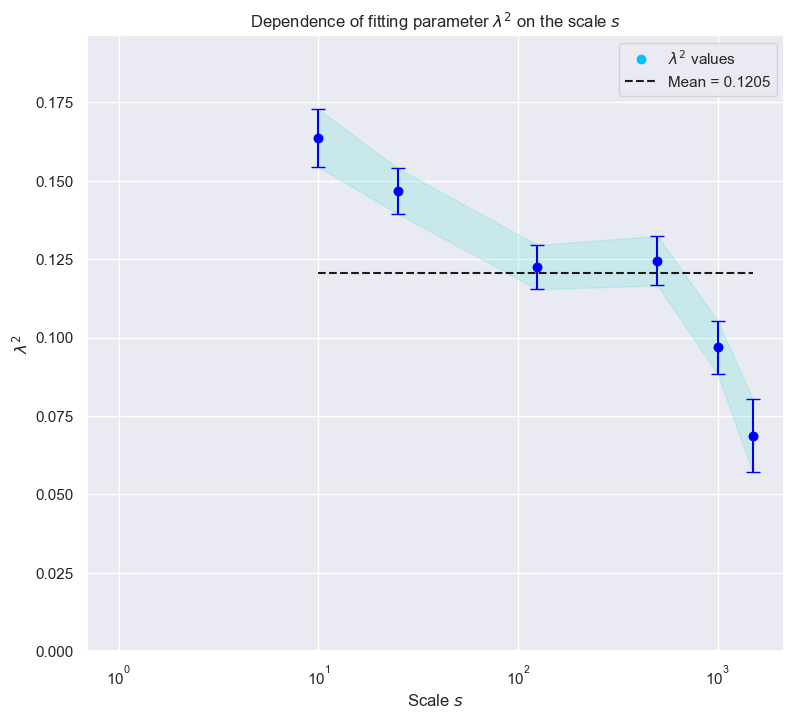

In [13]:

def plot_lambda(lambdas, lambdas_err, s_list):
    """
    Plots the values of lambda squared parameter obtained from Castaing function.
    """
    sns.set_style("darkgrid")

    fig, ax = plt.subplots(figsize=(9, 8))

    # Set x-axis to logarithmic scale
    ax.set_xscale("log")

    # Compute lambda^2 and its error

    lambdas_sqr = lambdas ** 2
    lambdas_err_sqr = 2 * lambdas * lambdas_err


    # Adjust y-axis limits
    ax.set_ylim([0, max(lambdas_sqr) * 1.2])


    # Plot data points
    ax.plot(s_list, lambdas_sqr, 'o', color='deepskyblue', label=r"$\lambda^2$ values")

    # Plot the error range for lambda^2
    ax.fill_between(s_list,
                    lambdas_sqr - lambdas_err_sqr,
                    lambdas_sqr + lambdas_err_sqr,
                    alpha=0.2, color='turquoise')

    # Plot error bars
    ax.errorbar(s_list, lambdas_sqr, yerr=lambdas_err_sqr, fmt='o', capsize=5, color='blue')

    # Plot the mean lambda^2 value
    mean_lambda_sqr = lambdas_sqr.mean()
    ax.hlines(mean_lambda_sqr, min(s_list), max(s_list), colors="k", linestyles="--", label=f"Mean = {mean_lambda_sqr:.4f}")

    ax.set_title(r"Dependence of fitting parameter $\lambda^2$ on the scale $s$")
    ax.set_xlabel(r"Scale $s$")
    ax.set_ylabel(r"$\lambda^2$")

    ax.legend()

    plt.show()

print(lambdas)
plot_lambda(lambdas, lambdas_err, s_list )

**key observations**


At small scales (s<10), λ**2 is higher and has greater uncertainty.


As s increases, λ**2 shows a decreasing trend.

Around s≈100, λ**2 stabilizes close to the mean value.

For very large scales (s>1000), λ2 decreases significantly.

**Physical Interpretation:**

The decrease in λ2 at larger scales suggests that small-scale fluctuations diminish(cause otherwise,
If the exponent becomes too negative, some values of σσ will have nearly zero probability) leading the system towards a more Gaussian-like behavior. This behavior could indicate the effect of diffusion-like processes or scale invariance properties.

**Question:**

Why did we use a logarithmic scale for the horizontal axis (s)?


*   Examining variations at both large and small scales
If the horizontal axis were linear, smaller values of ss (e.g., 1010 and 100100) would appear very close together on the graph, while larger values of ss (e.g., 10001000) would be stretched out on the right side. In a logarithmic scale, these values are distributed more proportionally, allowing for better visualization of both small and large scales.
*    If the variation of λ2λ2 follows a power-law relationship, it will appear as a straight line in this scale, making the trend analysis much easier.


#scale invariance

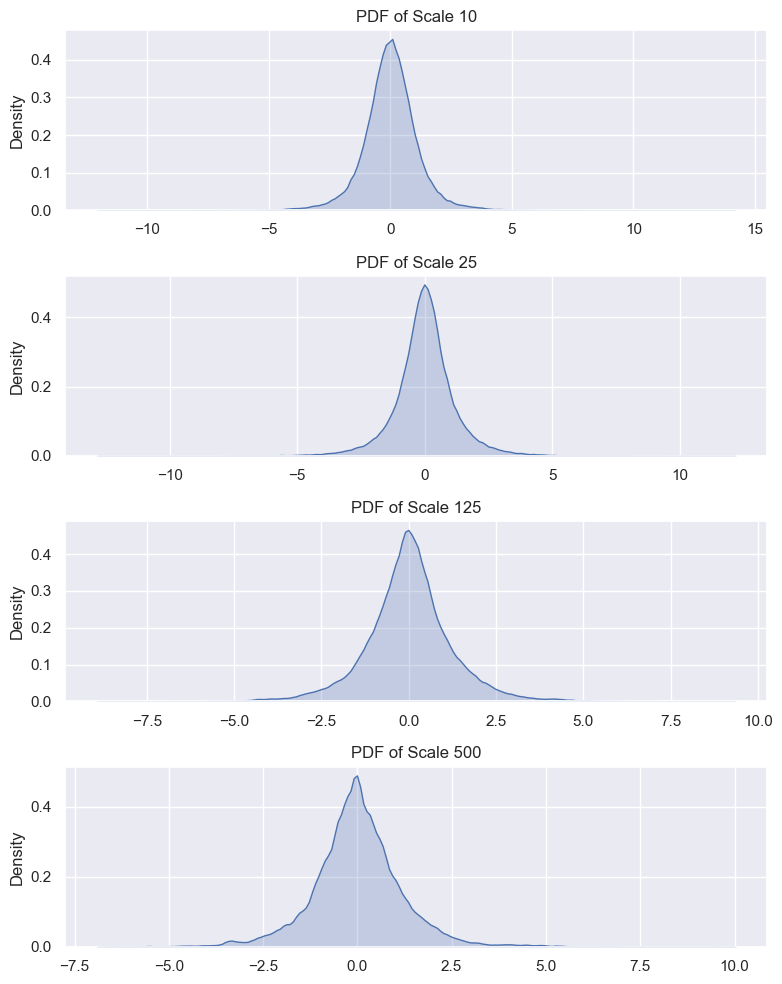

In [14]:



# List of rows to be displayed
selected_rows = [0,1,2,3]

# Plot the Probability Density Function (PDF) for the selected rows
plt.figure(figsize=(8, 10))
for i, row in enumerate(selected_rows):
    plt.subplot(len(selected_rows), 1, i + 1)
    sns.kdeplot(df.iloc[row].dropna().to_numpy(), bw_adjust=0.5, fill=True)
    plt.title(f"PDF of Scale {df.index[row]}")

plt.tight_layout()
plt.show()

**key observation**


The probability density function (PDF) of heart rate
fluctuations is scale invariant.

#conclusion

If the data had fit a Gaussian distribution, we could infer that heart rate variations result from a simple, independent, and normally distributed stochastic process.
If the data had matched the cascade model, it would suggest that heart rate variations stem from a multiscale process similar to turbulence.

However, since neither of these models accurately describes heart rate variations, it indicates that heart rate dynamics are not purely random but follow a structured and law-governed mechanism.

✅ These findings suggest that heart rate dynamics behave more like a system near a critical state, where variations exhibit scale-invariant properties and a complex, self-organized structure